In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

import os 

os.chdir('../')
from utils import bootsratp
os.chdir('jupyter_notebooks')

# from urbansim_templates import modelmanager
# from urbansim_templates.models import BinaryLogitStep
# import orca

## Exploratory Data Analysis 

In [18]:
## Load raw data 
persons = pd.read_csv('NHTS_2017/perpub.csv')
households = pd.read_csv('NHTS_2017/hhpub.csv')

## Bay area households 
ba_filter = households['HH_CBSA'].isin(['41860','41940'])
households = households[ba_filter]
print ('Bar area household sample size:', ba_filter.sum())

## Avoid duplicated columns (to preserve column name in future merge)
cols_to_use = persons.columns.difference(households.columns)
cols_to_use = list(cols_to_use)
cols_to_use.insert(0,'HOUSEID')

## Merge persons and households tables 
persons = persons[cols_to_use].merge(households, how = 'right', on = 'HOUSEID')
population = np.round(persons['WTPERFIN'].sum(), 0)

print ('Bar area persons sample size:', persons.shape[0])
print ('Bar area weighted persons sample size:', population)

Bar area household sample size: 3248
Bar area persons sample size: 6772
Bar area weighted persons sample size: 6937089.0


In [19]:
## Initial data cleaning 
no_sector = persons['OCCAT'].isin([-9, -8, -7, -1, 97])

print ('Job sector model has {} observations'.format(~no_sector.sum()))

sector_name = {1: 'Sales or service', 2:'Clerical or administrative support', 
               3:'Manufacturing, construction, maintenance, or farming', 
               4:'Professional, managerial, or technical'}

Job sector model has -3133 observations


In [20]:
workers = persons[persons['OCCAT'].isin([1, 2, 3, 4])]

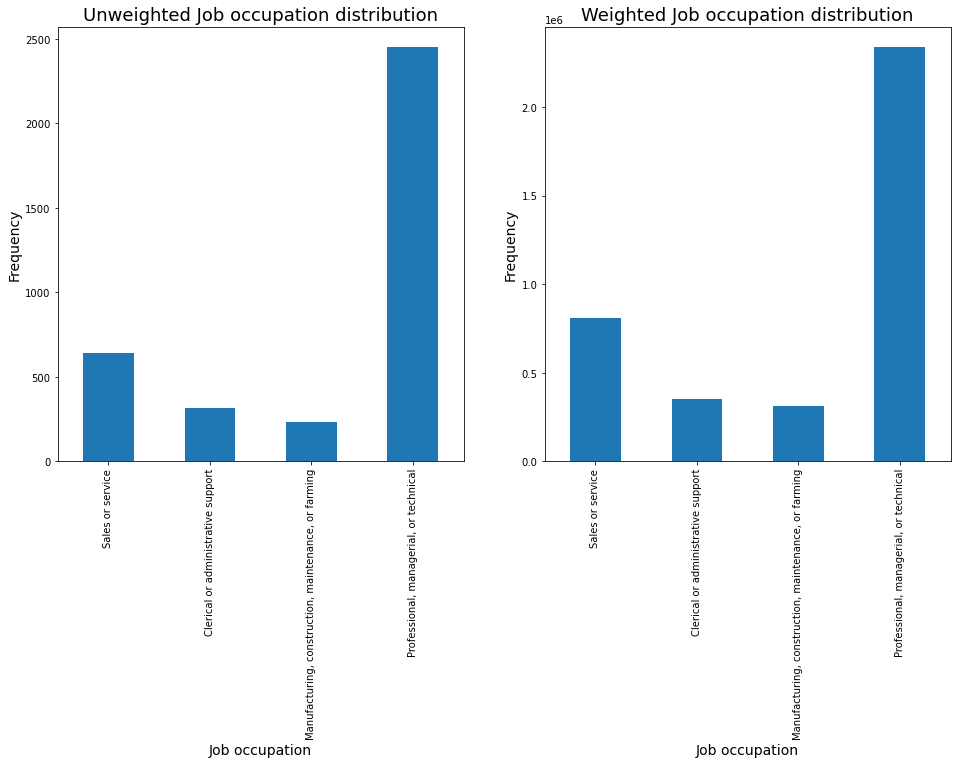

In [21]:
workers

fig, axs = plt.subplots(1,2, figsize = (16,8))
# Unweighted
to_plot_0 = workers['OCCAT'].value_counts().sort_index().rename(sector_name, axis = 0)
to_plot_0.plot.bar(ax = axs[0])
axs[0].set_xlabel('Job occupation', fontsize = 14)
axs[0].set_ylabel('Frequency', fontsize = 14)
axs[0].set_title('Unweighted Job occupation distribution', fontsize = 18)

# Weighted
to_plot_1 = workers.groupby('OCCAT').agg({'WTPERFIN':'sum'}).rename(sector_name, axis = 0)['WTPERFIN']
to_plot_1.plot.bar(ax = axs[1])
axs[1].set_xlabel('Job occupation', fontsize = 14)
axs[1].set_ylabel('Frequency', fontsize = 14)
axs[1].set_title('Weighted Job occupation distribution', fontsize = 18);

The Job Category is mainly dominated by Professional, managerial, or techinal. In the work as an option model, we found there was a big difference between this category and the other. For this reason, devide Job Sector in two Categories. 0 = Others, 1 = Professional, managerial, or techinal. 

In [22]:
workers['OCCAT'].value_counts()

4    2451
1     639
2     314
3     236
Name: OCCAT, dtype: int64

In [23]:
workers['job'] = (workers['OCCAT'] == 4).astype(int)
workers.job.value_counts()

1    2451
0    1189
Name: job, dtype: int64

In [24]:
# Correlation Analysis 
pearson_corr = workers.corr().loc['job'].abs().sort_values()
best_corr = pearson_corr[pearson_corr > 0.15].sort_values(ascending=False)
print ('There are {} variables with a absolute pearson correlation greater than 0.15.\nThese variables are: {}'.format(len(best_corr), list(best_corr.index)))

There are 13 variables with a absolute pearson correlation greater than 0.15.
These variables are: ['job', 'OCCAT', 'EDUC', 'HHFAMINC', 'PERSONID', 'NUMADLT', 'R_RELAT', 'HHVEHCNT', 'WHOPROXY', 'FLEXTIME', 'WTHHFIN', 'WTPERFIN', 'WRKCOUNT']


In [25]:
best_corr

job         1.000000
OCCAT       0.925058
EDUC        0.495278
HHFAMINC    0.234140
PERSONID    0.208311
NUMADLT     0.176115
R_RELAT     0.172518
HHVEHCNT    0.162159
WHOPROXY    0.160678
FLEXTIME    0.160323
WTHHFIN     0.159746
WTPERFIN    0.154035
WRKCOUNT    0.150517
Name: job, dtype: float64

Shortlisted: 
- EDUC: Educational Attainment
    - Less than Bachelors 
    - Bachelors
    - Graduate Degree 
- HHFAMINC: Household Income [DO NOT INCLUDE: This variable is included in work from home option]
- NUMADLT: Numer of Adults
    - 1-2 Adults 
    - 3+ Adults
- R_RELAT: Relationship (self, partner, child, etc)
    - Self - partner/spouse
    - Other
- HHVEHCNT: Count of Household Vehicles.[Likely to drop]
    - 0-2 Cars 
    - 3+ Cars 
- WRKCOUNT: Number of Workers
    - 1-2 Workers 
    - 3+ workers 

Some additional variables 
- R_AGE_IMP: Age [NOT RELEVANT]
- R_SEX_IMP: Gender Imputed [NOT RELEVANT]
- NOCONG: Trip Time Minutes to Work without Traffic [NOT RELEVANT]

Not included: 
- job: Same Variable 
- OCCAT: Same variable
- HHFAMINC
- PERSONID: Unique identifier
- WHOPROXY: Household person identifier
- WTHHFIN: Final HH weights
- WTPERFIN: Final Person weight

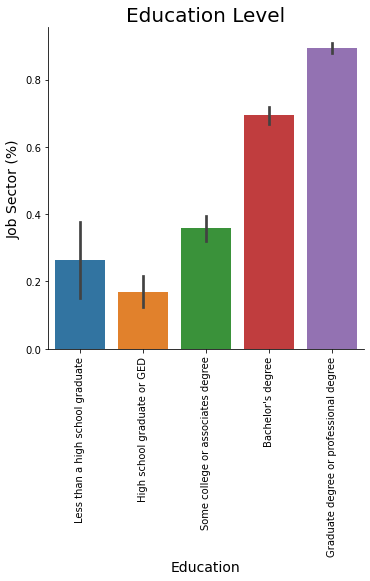

In [26]:
educ_labels = ['Less than a high school graduate', 
                'High school graduate or GED',
                'Some college or associates degree',
                "Bachelor's degree" ,
                "Graduate degree or professional degree" ]

sns.catplot(x="EDUC", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
plt.xlabel('Education',fontsize = 14)
plt.title('Education Level', fontsize = 20)
plt.xticks([0,1,2,3,4], educ_labels, rotation = 90);

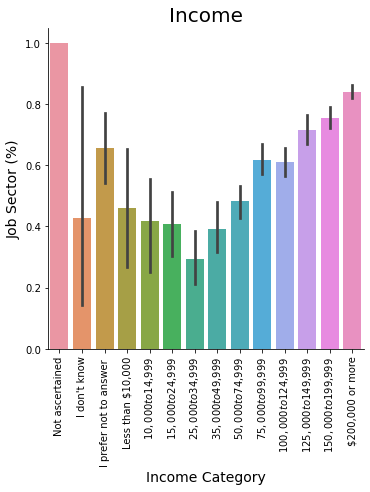

In [27]:
income_labels = ['Not ascertained', "I don't know",  "I prefer not to answer ",
"Less than $10,000", "$10,000 to $14,999", '$15,000 to $24,999' , 
'$25,000 to $34,999', '$35,000 to $49,999', '$50,000 to $74,999', 
'$75,000 to $99,999','$100,000 to $124,999','$125,000 to $149,999',
'$150,000 to $199,999','$200,000 or more']

sns.catplot(x="HHFAMINC", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
plt.xlabel('Income Category',fontsize = 14)
plt.title('Income', fontsize = 20)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13],labels = income_labels, rotation = 90);

2    2310
1     603
3     442
4     208
5      52
6      15
7      10
Name: NUMADLT, dtype: int64

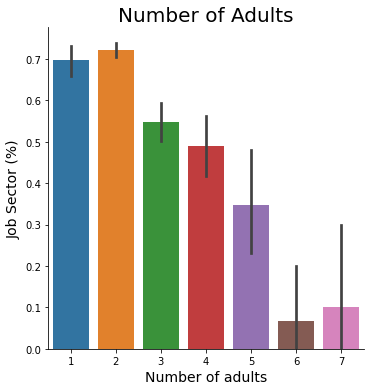

In [28]:
sns.catplot(x="NUMADLT", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
plt.xlabel('Number of adults',fontsize = 14)
plt.title('Number of Adults', fontsize = 20);
workers.NUMADLT.value_counts()

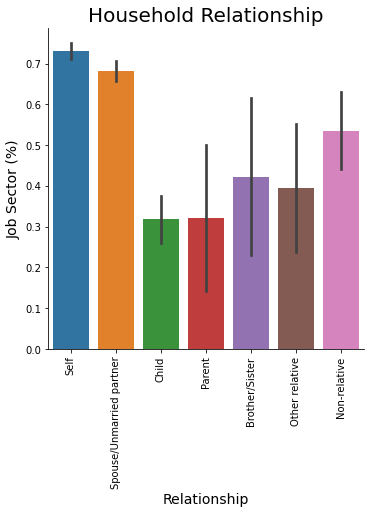

In [29]:
# R_RELAT
relat_labels = ['Self','Spouse/Unmarried partner','Child', 
                'Parent','Brother/Sister', 'Other relative',
                'Non-relative']

sns.catplot(x="R_RELAT", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
plt.xlabel('Relationship',fontsize = 14)
plt.title('Household Relationship', fontsize = 20)
plt.xticks(ticks = [0,1,2,3,4,5,6],labels = relat_labels , rotation = 90);

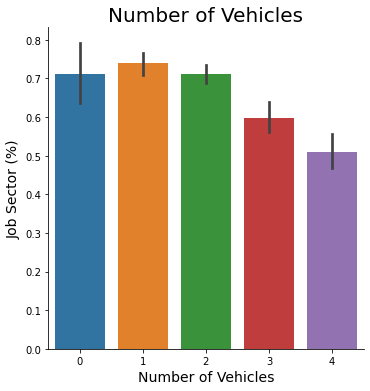

In [30]:
workers['cars'] = workers.HHVEHCNT.mask(workers.HHVEHCNT > 4, 4)
sns.catplot(x="cars", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
plt.xlabel('Number of Vehicles',fontsize = 14)
plt.title('Number of Vehicles', fontsize = 20);

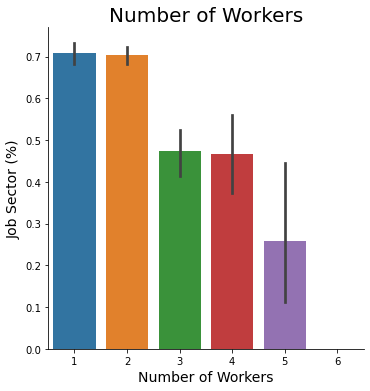

In [31]:
sns.catplot(x='WRKCOUNT', y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
plt.xlabel('Number of Workers',fontsize = 14)
plt.title('Number of Workers', fontsize = 20);

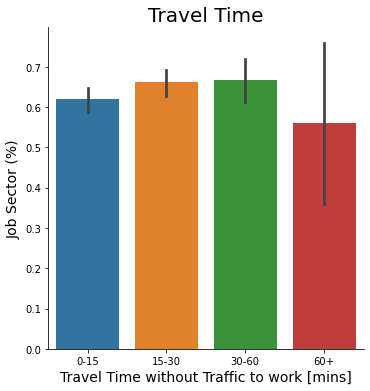

In [32]:
workers['time_to_work']=pd.cut(
                        workers[workers['NOCONG']>0]['NOCONG'], 
                        bins = (0,15,30,60,211), 
                        labels=['0-15','15-30','30-60','60+'])
sns.catplot(x="time_to_work", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
plt.xlabel('Travel Time without Traffic to work [mins]',fontsize = 14)
plt.title('Travel Time', fontsize = 20);

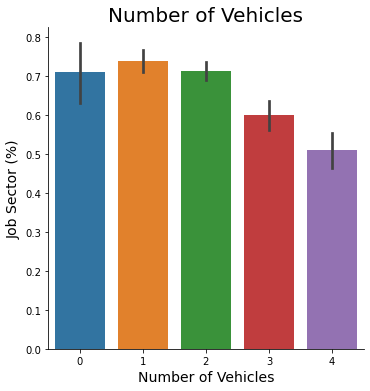

In [33]:
workers['cars'] = workers.HHVEHCNT.mask(workers.HHVEHCNT > 4, 4)
sns.catplot(x="cars", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
plt.xlabel('Number of Vehicles',fontsize = 14)
plt.title('Number of Vehicles', fontsize = 20);

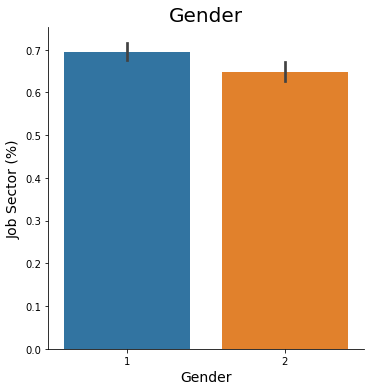

In [34]:

sns.catplot(x="R_SEX_IMP", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
plt.xlabel('Gender',fontsize = 14)
plt.title('Gender', fontsize = 20);

## Job Sector Model

Acording to the EDA, the most important variables for the job sector model are: 
- EDUC: Education Level
- WRKCOUNT: Number of Workers 
- R_RELAT: Relationship

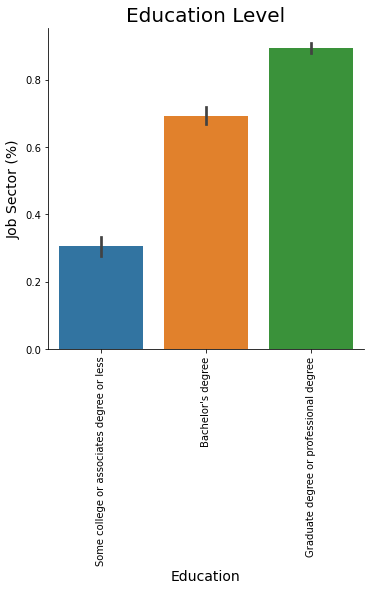

In [45]:
workers['education_category'] = pd.cut(workers.EDUC, bins = (0,3,4,5), labels = [0,1,2])
educ_labels = ['Some college or associates degree or less', "Bachelor's degree",
                "Graduate degree or professional degree"]

sns.catplot(x="education_category", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
plt.xlabel('Education',fontsize = 14)
plt.title('Education Level', fontsize = 20)
plt.xticks([0,1,2], educ_labels, rotation = 90);

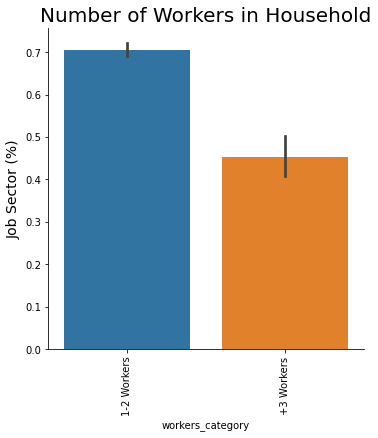

In [46]:
workers['workers_category'] = pd.cut(workers.WRKCOUNT, bins = (0,2,10), labels = [0,1])
workers_labels = ['1-2 Workers', '+3 Workers']

sns.catplot(x="workers_category", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
# plt.xlabel('Number of Workers in Household',fontsize = 14)
plt.title('Number of Workers in Household', fontsize = 20)
plt.xticks([0,1], workers_labels, rotation = 90);

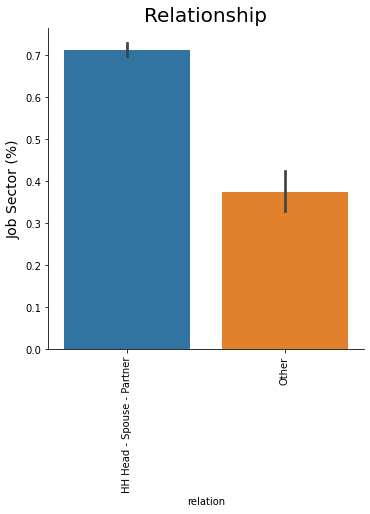

In [38]:
workers['relation'] = pd.cut(workers.R_RELAT, bins = (0,2,10), labels = [0,1])

relation_labels = ['HH Head - Spouse - Partner', 'Other']

sns.catplot(x="relation", y="job", kind="bar", data=workers)
plt.ylabel('Job Sector (%)',fontsize = 14);
# plt.xlabel('Number of Workers in Household',fontsize = 14)
plt.title('Relationship', fontsize = 20)
plt.xticks([0,1], relation_labels, rotation = 90);

In [47]:
bootsratp(workers, 'job', ['education_category',
                           'workers_category','relation'], func= 'mean')

mean  count  lower_bound  \
education_category workers_category relation                                 
0                  0                0         0.337058    625     0.298823   
                                    1         0.245171    102     0.159243   
                   1                0         0.385296     80     0.280722   
                                    1         0.165128    140     0.103454   
1                  0                0         0.722248   1015     0.695711   
                                    1         0.585442     75     0.474493   
                   1                0         0.542385     72     0.432080   
                                    1         0.537335     67     0.416578   
2                  0                0         0.905490   1341     0.889165   
                                    1         0.705866     21     0.508354   
                   1                0         0.777203     81     0.691027   
                                    1         0.810711     21     0.638588   

                                              upper_bound  
education_category workers_category relation               
0                  0                0            0.375292  
                                    1            0.331098  
                   1                0            0.489870  
                                    1            0.226801  
1                  0                0            0.748785  
                                    1            0.696391  
                   1                0            0.652690  
                                    1            0.658092  
2                  0                0            0.921815  
                                    1            0.903378  
                   1                0            0.863378  
                                    1            0.982833

Adding relatioship seems to make some categories with less than 30 observations. 

In [60]:
categories = ['education_category','workers_category']
job_sector_table = bootsratp(workers, 'job', categories, func= 'mean')
job_sector_model = job_sector_table.reset_index()[categories + ['mean']].rename(columns = {'mean':'rate'})

In [62]:
job_sector_model.to_csv('telework_job_setor_rates.csv', index=False)

## Variables in Synthetic Population

In [10]:
persons = pd.read_csv('../bay_area_base/data/persons.csv')
households = pd.read_csv('../bay_area_base/data/households.csv')

In [13]:
education_category = pd.cut(persons.edu,[-1,20,21,25], labels = [0,1,2])
workers_category = pd.cut(households.workers, [-1,2,20], labels = [0,1])